In [ ]:
import scipy.io
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import expit
from decimal import Decimal
from keras.datasets import mnist
from sklearn.model_selection import train_test_split

# Artificial Neural Networks

Here we will take a closer look at Neural Netorks, also known as Artificial Neural Networks (ANN) to destinuish them from their biological counterparts and Convolutional Neural Networks (CNN); which will be covered in the next session.

ANNs simulate the brain architecture in that neurons take gets input from synapses and give output to other neurons, thereby forming a directed graph.  

![General neural net graph](./images/general-ann.png)

The topology of this graph can be quite diverse, however we will start with a simple example. We will tag some nodes as special input nodes and some as special output nodes. This is were we will attach the input-output training data to later. The rest of the nodes are simply called "hidden nodes"

![Simple ANN](./images/Artificial_neural_network.svg)

A single neuron takes multiple inputs $x_i$ and give a single output (possible to more than one reciever). The inputs are weighted by some $\theta_i$ to compute an *activation*

$z = \theta_1 x_1 + \theta_2 x_2 + ... + \theta_n x_n$

In [1]:
def activation(x, theta):
    answer = 0
    for i in range(len(x)):
        answer += x[i]*theta[i]
    return answer

However the activation is typically passed through an activation function. This introduces non-linearity into the formulation which greatly helps in generalizing to complex problems. Different activation functions are available, but the two must videly used are the

## sigmoid function

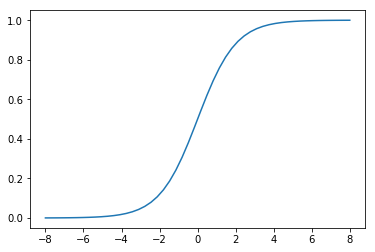

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(z):
    return 1 / (1+np.exp(-z))

z = np.linspace(-8,8)
plt.plot(z, sigmoid(z))
plt.show()



## rectified linear unit (relu)

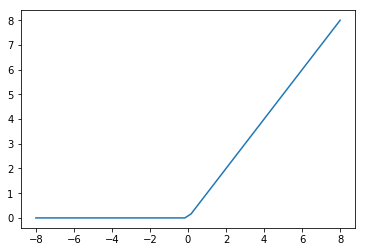

In [3]:
def relu(z):
    return np.maximum(z,0)

z = np.linspace(-8,8)
plt.plot(z, relu(z))
plt.show()

a single neuron with input weights $\theta_i$ can then be programmed as

In [4]:
def neuron(x,theta):
    return sigmoid(activation(x,theta))

if one choses the sigmoid activation function. Theentire network described above can be written as

In [5]:
# define some input vector
x = [1,3,13]

# compute output for hidden units
a1 = neuron(x, [1,1,1]) # output from hidden neuron 1 using weights [1,1,1]
a2 = neuron(x, [1,2,1]) # output from hidden neuron 2 using weights [1,2,1]
a3 = neuron(x, [3,2,1]) # output from hidden neuron 2 using weights [3,2,1]
a4 = neuron(x, [0,0,1]) # output from hidden neuron 2 using weights [0,0,1]
a  = [a1,a2,a3,a4]      # wrap all hidden values into a vector

# compute output nodes
y1 = neuron(a, [0,0,1,3]) # output neuron 1 using weights [0,0,1,3]
y2 = neuron(a, [3,9,1,0]) # output neuron 2 using weights [3,9,1,0]

We note that every neuron $i$ has a different weight $\theta_j$ and we often denote $\Theta_{ij}$

$a = \sigma(\Theta x)$

Likewise, the output nodes will also have different weights and we write

$y = \sigma(\Theta^{(2)} a)$

where $\sigma(\cdot)$ is the activation function (here: sigmoid function). $\Theta^{(2)} =\left[\begin{array}{cccc} 0 & 0 & 1 & 3 \\ 3 & 9 & 1 & 0 \end{array}\right]$ in this particular case. This vectorization allow us to create fast implementations of neural networks. $x$ and $y$ are as usual treated as the input and output respectively, while intermediate results are denoted $p$. 

Due to the optimzation possibilities, these *feed forward* networks have become very popular. We can extend this be adding more layers to it. By adding another layer we can start with a vector $x$, then compute a vector $p_1$ using a matrix of weights $\Theta^{(1)}$. Subsequently we compute a vector $p_2$ using a matrix of weights $\Theta^{(2)}$ followed by an output using $\Theta^{(3)}$, giving the following network

![Neural network with 2 hidden layers](./images/Artificial_neural_network_2layers.svg)

We can control the architecture of the network and the activation functions used, but will not manually specify the weights $\Theta$. This is trained using optimization algorithms using [backpropagation](https://en.wikipedia.org/wiki/Backpropagation).

## House price regression using neural networks

For a single hidden layer neural network, then this collapses to logistic regression. We will here implement the network outlined above with a single output neuron

In [6]:
# Read and normalize features
def featureNormalize(X):
    X_norm = X
    mu    = np.zeros((1, X.shape[1]))
    sigma = np.zeros((1, X.shape[1]))
    for i in range(X.shape[1]):
        mu[:,i] = np.mean(X[:,i])
        sigma[:,i] = np.std(X[:,i])
        X_norm[:,i] = (X[:,i] - float(mu[:,i]))/float(sigma[:,i])
    return X_norm, mu, sigma

data = np.loadtxt('./data/housing_data.csv', delimiter=",")
X = data[:,:2]
y = data[:,2]
m = len(y)


We will in the following use the square sum loss function
$$
J(\Theta) = \frac{1}{2m}\sum(y-y_p)^2
$$
with the following gradient
$$
\frac{\partial J}{\partial \Theta_ij} = \frac{1}{m}\sum(y-y_p)^2
$$

In [7]:
def cost(W,X,y):
    (n,m) = X.shape # n features, m training examples
    
    Theta1 = np.reshape(W[  : 9], (3,3))
    Theta2 = np.reshape(W[ 9:25], (4,4))
    Theta3 = np.reshape(W[25:  ], (5,1))
    z1 = Theta1 * np.vstack(np.ones((1,m)),  X)
    a1 = sigmoid(z1)
    z2 = Theta2 * np.vstack(np.ones((1,m)), a1)
    a2 = sigmoid(z2)
    z3 = Theta3 * np.vstack(np.ones((1,m)), a2)
    yp = sigmoid(z3) # predicted values for one feed-forward iteration
    
    loss = np.sum((yp-y)**2) / 2 / m
    
    # compute the jacobian by partial differentiation
    return (loss, jacobian)

In [8]:
print('Training Neural Network...')
maxiter = 1000
lambda_reg = 0.1
results = minimize(cost, x0=nn_params, args=(X,y), options={'disp': True, 'maxiter':maxiter}, method="L-BFGS-B", jac=True)

all_weights = results["x"]

Theta1 = np.reshape(all_weights[  : 9], (3,3), order='F')
Theta2 = np.reshape(all_weights[ 9:25], (4,4), order='F')
Theta3 = np.reshape(all_weights[25:  ], (5,1), order='F')


Training Neural Network...


NameError: name 'minimize' is not defined

In [9]:
def displayData(X, example_width=None):
    m,n = X.shape
    plt.figure(figsize=(16,16))
    if X.ndim == 1:
        X = np.reshape(X, (-1,m))
    if not example_width or not 'example_width' in locals():
        example_width = int(round(math.sqrt(X.shape[1])))
    plt.set_cmap("gray")
    example_height = n / example_width
    display_rows = int(math.floor(math.sqrt(m)))
    display_cols = int(math.ceil(m / display_rows))
    pad = 1
    display_array = -np.ones((pad + display_rows * int(example_height + pad),  pad + display_cols * int(example_width + pad)))
    curr_ex = 1
    for j in range(1,display_rows+1):
        for i in range (1,display_cols+1):
            if curr_ex > m:
                break
            max_val = max(abs(X[curr_ex-1, :]))
            rows = pad + (j - 1) * (int(example_height) + pad) + np.array(range(int(example_height)))
            cols = pad + (i - 1) * (int(example_width)  + pad) + np.array(range(int(example_width)))
            display_array[rows[0]:rows[-1]+1 , cols[0]:cols[-1]+1] = np.reshape(X[curr_ex-1, :], (int(example_height), int(example_width)), order="F") / max_val
            curr_ex += 1
            if curr_ex > m:
                break
    h = plt.imshow(display_array.T, vmin=-1, vmax=1)
    plt.axis('off')
    plt.show(block=False)
    return h, display_array

In [10]:
def predict(Theta1, Theta2, X):
    if X.ndim == 1:
        X = np.reshape(X, (-1,X.shape[0]))
    m = X.shape[0]
    p = np.zeros((m,1))
    X = np.column_stack((np.ones((m,1)), X))
    a2 = sigmoid( np.dot(X,Theta1.T) )
    a2 = np.column_stack((np.ones((a2.shape[0],1)), a2))
    a3 = sigmoid( np.dot(a2,Theta2.T) )
    p = np.argmax(a3, axis=1)
    return p + 1

# Architecture of Deep Neural Network, Cost Function and Regularization
<img src='./images/dnncost.jpg'>

In [11]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, \
	num_labels, X, y, lambda_reg):
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], \
                     (hidden_layer_size, input_layer_size + 1), order='F')

    Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], \
                     (num_labels, hidden_layer_size + 1), order='F')
    m = len(X)
    J = 0;
    Theta1_grad = np.zeros( Theta1.shape )
    Theta2_grad = np.zeros( Theta2.shape )
    X = np.column_stack((np.ones((m,1)), X)) # = a1
    a2 = sigmoid( np.dot(X,Theta1.T) )
    a2 = np.column_stack((np.ones((a2.shape[0],1)), a2))
    a3 = sigmoid( np.dot(a2,Theta2.T) )

    labels = y
    #One hot encoding
    y = np.zeros((m,num_labels))
    for i in range(m):
    	y[i, labels[i]-1] = 1

    cost = 0
    for i in range(m):
    	cost += np.sum( y[i] * np.log( a3[i] ) + (1 - y[i]) * np.log( 1 - a3[i] ) )
    J = -(1.0/m)*cost
    sumOfTheta1 = np.sum(np.sum(Theta1[:,1:]**2))
    sumOfTheta2 = np.sum(np.sum(Theta2[:,1:]**2))
    J = J + ( (lambda_reg/(2.0*m))*(sumOfTheta1+sumOfTheta2) )
    bigDelta1 = 0
    bigDelta2 = 0
    for t in range(m):
        x = X[t]
        a2 = sigmoid( np.dot(x,Theta1.T))
        a2 = np.concatenate((np.array([1]), a2))
        a3 = sigmoid( np.dot(a2,Theta2.T) )
        delta3 = np.zeros((num_labels))
        for k in range(num_labels):
            y_k = y[t, k]
            delta3[k] = a3[k] - y_k
        delta2 = (np.dot(Theta2[:,1:].T, delta3).T) * sigmoidGradient( np.dot(x, Theta1.T) )
        bigDelta1 += np.outer(delta2, x)
        bigDelta2 += np.outer(delta3, a2)
    Theta1_grad = bigDelta1 / m
    Theta2_grad = bigDelta2 / m
    Theta1_grad_unregularized = np.copy(Theta1_grad)
    Theta2_grad_unregularized = np.copy(Theta2_grad)
    Theta1_grad += (float(lambda_reg)/m)*Theta1
    Theta2_grad += (float(lambda_reg)/m)*Theta2
    Theta1_grad[:,0] = Theta1_grad_unregularized[:,0]
    Theta2_grad[:,0] = Theta2_grad_unregularized[:,0]
    grad = np.concatenate((Theta1_grad.reshape(Theta1_grad.size, order='F'), Theta2_grad.reshape(Theta2_grad.size, order='F')))
    return J, grad

In [12]:
def randInitializeWeights(L_in, L_out):
    W = np.zeros((L_out, 1 + L_in))
    epsilon_init = 0.12
    W = np.random.rand(L_out, 1 + L_in)*(2*epsilon_init) - epsilon_init
    return W

In [13]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

NameError: name 'mnist' is not defined

In [14]:
# building the input vector from the 28x28 pixels
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
_,input_layer_size  = X_train.shape  
hidden_layer_size = 25   # 25 hidden units
num_labels = 10

NameError: name 'X_train' is not defined

# Resulting 2 Layer Neural Network
<img src='./images/ann.jpg'>

In [15]:
X=X_train
y=y_train
m,n=X.shape
y=y.flatten()
rand_indices = np.random.permutation(m)
random_images = X[rand_indices[:100],:]
displayData(random_images);

NameError: name 'X_train' is not defined

In [16]:
Theta1=randInitializeWeights(input_layer_size,hidden_layer_size)
Theta2=randInitializeWeights(hidden_layer_size, num_labels)
nn_params = np.concatenate((Theta1.reshape(Theta1.size, order='F'), Theta2.reshape(Theta2.size, order='F')))#

NameError: name 'input_layer_size' is not defined

In [17]:
print('Training Neural Network...')
maxiter = 1000
lambda_reg = 0.1
myargs = (input_layer_size, hidden_layer_size, num_labels, X, y, lambda_reg)
results = minimize(nnCostFunction, x0=nn_params, args=myargs, options={'disp': True, 'maxiter':maxiter}, method="L-BFGS-B", jac=True)

nn_params = results["x"]

Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], \
                 (hidden_layer_size, input_layer_size + 1), order='F')

Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], \
                 (num_labels, hidden_layer_size + 1), order='F')

Training Neural Network...


NameError: name 'input_layer_size' is not defined

In [18]:
print('\nVisualizing Neural Network layer 1 \n')
displayData(Theta1[:, 1:]);


Visualizing Neural Network layer 1 



NameError: name 'Theta1' is not defined

In [19]:
print('\nVisualizing Neural Network layer 1 \n')
displayData(Theta2[:, 1:]);


Visualizing Neural Network layer 1 



NameError: name 'Theta2' is not defined

In [20]:
pred = predict(Theta1, Theta2, X)

NameError: name 'Theta1' is not defined

In [21]:
# uncomment code below to see the predictions that don't match
# fmt = '{}   {}'
# print(fmt.format('y', 'pred'))
# for y_elem, pred_elem in zip(y, pred):
#     if y_elem != pred_elem:
#         print(fmt.format(y_elem%10, pred_elem%10))

print('Training Set Accuracy: {:f}'.format( ( np.mean(pred == y)*100 ) ) )

#for i in range(m):
#    print('Displaying Example Image')
#    displayData(X[rp[i], :].reshape(1,-1))
#    pred = predict(Theta1, Theta2, X[rp[i], :])
#    print('Neural Network Prediction: {:d} (digit {:d})'.format(pred[0], (pred%10)[0]))
#    input('Program paused. Press enter to continue.\n')

NameError: name 'pred' is not defined

# Solve using Keras with Tensorflow backend

In [ ]:
reset

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from decimal import Decimal
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.datasets import mnist

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
_,input_layer_size  = X_train.shape  
X=X_train
y=y_train
m,n=X.shape
y=y.flatten()
rand_indices = np.random.permutation(m)
random_images = X[rand_indices[:100],:]
displayData(random_images);
num_labels=np.unique(y).shape [0]

In [ ]:
#One hot encoding
y = np_utils.to_categorical(y)
print("Shape of y ",y.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
ANN_classifier = Sequential()
ANN_classifier.add(Dense(units = 25, kernel_initializer = 'normal', activation = 'relu', input_dim = input_layer_size))
ANN_classifier.add(Dense(units = num_labels, kernel_initializer = 'uniform', activation = 'softmax'))
ANN_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history=ANN_classifier.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size = 100, epochs = 10)

In [ ]:
#Create randomized index
rp = np.random.permutation(len(X_test))
#Try out on the data
for i in range(3):
    print('Displaying Example Image')
    displayData(X_test[rp[i], :].reshape(1,-1))
    pred = ANN_classifier.predict(X_test[rp[i],:].reshape(1,-1))
    print('Neural Network Prediction: ',np.argmax(pred))
    input('Program paused. Press enter to continue.\n')
    